# Классификация текста с помощью трансформеров: сравнительный анализ с традиционными методами.

Автор: [Григорьев Виталий](https://github.com/vi21g), студент "академии нейросетей THE FOUNDER".

## Аннотация

В данной работе проводится сравнительный анализ эффективности современных трансформерных моделей (на примере дообученной BERT-подобной архитектуры) и классических методов машинного обучения, таких как Logistic Regression, XGBoost и SVM, в задаче классификации текстов. Основная цель работы — определить, в каких сценариях трансформеры демонстрируют значительное преимущество перед традиционными подходами, а когда более простые методы остаются конкурентноспособными. Результаты могут быть полезны для выбора оптимального инструментария в прикладных NLP-задачах с учётом ограничений на вычислительные ресурсы.

## Установка и импорт библиотек

In [ ]:
!pip install pymorphy3
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6

In [ ]:
# для выдачи полного списка текущих библиотек
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.5.2
aiohappyeyeballs                   2.6.1
aiohttp                            3.11.14
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.23
albumentations                     2.0.5
ale-py                             0.10.2
altair                             5.5.0
annotated-types                    0.7.0
anyio                              4.9.0
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.7.1
arviz                              0.21.0
astropy                            7.0.1
astropy-iers-data                  0.2025.3.24.0.35.32
astunparse                         1.6.3
atpublic                           5.1
attrs                              25.3.0
audioread            

In [ ]:
# Стандартные модули
import os
import re
import string
import shutil

# Модули для работы с данными
import pandas as pd
import numpy as np
from pymorphy3 import MorphAnalyzer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Библиотеки машинного обучения
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             accuracy_score,
                             precision_score,
                             recall_score)
import xgboost as xgb
import torch
from transformers import (DistilBertTokenizer,
                          DistilBertForSequenceClassification,
                          Trainer,
                          TrainingArguments)

# Библиотеки для визуализации
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Дополнительные инструменты
import kagglehub

import wandb
wandb.init(mode="disabled") # явно задаём отключение логгирования wandb
os.environ["WANDB_DISABLED"] = "true"

import warnings
warnings.filterwarnings('ignore')

### Вспомогательные функции

In [ ]:
def plot_confusion_matrix(cm, model_name="", labels=['Positive', 'Negative']):
    """
    Построение матрицы ошибок.
    @param: cm: объект sklearn.metrics.confusion_matrix
    """
    plt.figure(figsize=(6, 4.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    title = f'Confusion Matrix{": " + model_name if model_name else ""}'
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('Actual label', fontsize=12)
    plt.show()

### Подключение google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Теоретическая часть

Классификация текста - одна из фундаментальных задач обработки естественного языка (NLP), имеющая широкое практическое применение: анализ тональности, категоризация документов, фильтрация спама и др. Традиционные методы машинного обучения (SVM, логистическая регрессия) и современные трансформерные архитектуры предлагают различные подходы к решению этой задачи. Сравнительный анализ их эффективности позволяет определить оптимальные методы для конкретных сценариев с учетом таких факторов как точность, скорость обучения и вычислительные ресурсы.

В данной работе проводится исследование в области бинарной классификации текста на русскоязычном датасете отзывов потребителей. Основная задача — определение тональности текста (позитивной или негативной) с учетом специфики русского языка и возможного дисбаланса классов.

### Постановка задачи

1. **Бинарная классификация текста**:  
   - Класс 0: позитивные отзывы  
   - Класс 1: негативные отзывы  

2. **Дисбаланс классов**:  
   - В исходном датасете распределение классов может быть неравномерным  
   - Будет исследовано влияние upsampling (искусственного увеличения минорного класса) на качество модели  

3. **Выбор оптимальной архитектуры**:  
   - Сравнение трансформерной модели (DistilBERT) с традиционными методами ML (SVM, Logistic Regression, XGBoost)  
   - Критерий выбора — метрики качества (F1-score, Accuracy, Precision-Recall)  

### Методология

#### 1. Предобработка данных
- Очистка текста (удаление пунктуации, хештегов, лишних пробелов)  
- Лемматизация (приведение слов к нормальной форме)  
- Исправление опечаток (частичное)  

#### 2. Балансировка классов
- Анализ исходного распределения классов  
- Применение upsampling для минорного класса (при необходимости)  
- Оценка влияния балансировки на качество классификации  

#### 3. Выбор модели
- **Трансформерная модель**:  
  - DistilBERT (оптимизированная версия BERT для многоязычных задач)  
  - Fine-tuning на датасете отзывов  

- **Традиционные методы ML**:  
  - SVM
  - Logistic Regression (с L2-регуляризацией)  
  - XGBoost (градиентный бустинг на деревьях)  

#### 4. Критерии оценки
- Основная метрика:  
  - **F1-score** (гармоническое среднее между precision и recall)  
     
- Определение оптимального подхода на основе сравнения метрик  


### Ожидаемые результаты
- Определение эффективности upsampling для данного датасета  
- Сравнение производительности DistilBERT и классических ML-методов  
- Выбор оптимального алгоритма для классификации тональности русскоязычных отзывов  

### Архитектура DistilBERT для бинарной классификации текста

Текст → Токенизация → Эмбеддинги → DistilBERT Encoder → Pooling → Классификатор → Прогноз

#### 1. Слой токенизации
- **Токенизатор**: `DistilBertTokenizer` (WordPiece)
- **Специальные токены**:
  - `[CLS]` - классификационный (добавляется в начало)
  - `[SEP]` - разделитель (не используется в бинарной классификации)
  - `[PAD]` - дополнение до максимальной длины
- **Максимальная длина**: 512 токенов (обрезание/патчинг при необходимости)


#### 2. Слой эмбеддингов
Комбинация двух типов эмбеддингов:
1. **Token Embeddings** (768-мерные)
   - Векторное представление каждого токена
   - Инициализируются предобученными весами

2. **Positional Embeddings** (768-мерные)
   - Кодируют позицию токена в последовательности
   - Фиксированные (не обучаемые в DistilBERT)

    [Входные токены] → [Lookup Embedding Table] → Сумма с Positional Embeddings] → [Нормализация]

#### 3. Трансформерный энкодер (6 слоев)
Каждый слой содержит:
- **Multi-Head Self-Attention** (12 голов)
  - Размерность ключей/запросов: 64 (768/12)
  - Механизм scaled dot-product attention
- **Feed Forward Network**:
  - Linear (768 → 3072) → GELU → Linear (3072 → 768)
- **Layer Normalization** после каждого подмодуля
- **Residual connections** вокруг основных блоков

#### 4. Пулинг (объединение)
- Используется представление токена `[CLS]` (первый токен)
- Этот вектор (768-мерный) содержит агрегированную информацию о всём тексте

#### 5. Классификационная голова
- **Структура**:

    [CLS] вектор → Dropout → Linear(768 → 2) → Softmax

## Подготовка данных

In [ ]:
# для воспроизводимости результатов
RANDOM_STATE = 42

In [ ]:
# загрузка датасета
path = kagglehub.dataset_download("kapturovalexander/consumer-sentiments-and-ratings")

print("Path to dataset files:", path)

100%|██████████| 2.57M/2.57M [00:00<00:00, 144MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kapturovalexander/consumer-sentiments-and-ratings/versions/4


In [ ]:
files = os.listdir(path)

print(files)

['market_comments.csv']


In [ ]:
dataframe = pd.read_csv(f'{path}/{files[0]}')
dataframe.head()

,item_category,item_id,brand,user_id,date,comment,rating,tonality
0,401,4010201,826,2217,2013-06-28,"2,5 года работала и все...устала! Лампочка гор...",2.0,negative
1,403,4030101,1425,1026,2010-07-04,Через 2 месяца после истечении гарантийного ср...,2.0,negative
2,401,4010401,124,2769,2010-05-27,пользуюсь уже три недели. нареканий ни каких н...,4.0,positive
3,203,2030301,93,508,2016-10-11,Ребят этот системный блок подойдёт для игры кс...,5.0,positive
4,205,2050201,656,1049,2010-02-26,"я считаю, что яри замечательный телефон! Прият...",5.0,positive


Для дальнейшей работы нам понадобится только два столбца:

1.   **comment** - текстовые данные
2.   **tonality** - метки, определим их как: **0** (позитивная оценка), **1** (негативная оценка)

Так же проведём стандартную очистку от пропусков и дубликатов


In [ ]:
dataframe_cleaned = dataframe[['comment', 'tonality']].copy()
dataframe_cleaned['tonality'] = dataframe_cleaned['tonality'].replace({'positive': 0, 'negative': 1})
dataframe_cleaned.dropna(inplace=True)
dataframe_cleaned.drop_duplicates(inplace=True)
dataframe_cleaned.reset_index(drop=True, inplace=True)
dataframe_cleaned

,comment,tonality
0,"2,5 года работала и все...устала! Лампочка гор...",1
1,Через 2 месяца после истечении гарантийного ср...,1
2,пользуюсь уже три недели. нареканий ни каких н...,0
3,Ребят этот системный блок подойдёт для игры кс...,0
4,"я считаю, что яри замечательный телефон! Прият...",0
...,...,...
14222,Не плохая машинка за такие деньги. Очень хорош...,0
14223,"Отличный кондиционер, работает тихо,в режиме н...",0
14224,Пылесос отличный. Мощный-это раз. Не по-детски...,0
14225,Три скорости,1


Сырые текстовые данные для улучшения модели требуется подготовить. Напишем функцию, выполняющую:



1.  Базовую очистку

    1.1.   Приведение к нижнему регистру

    1.2.   Удаление URL-адресов, хештегов, упоминаний пользователей

    1.3.   Удаление специальных символов и пунктуации

    1.4.   Нормализация пробелов


2.   Лингвистическая обработка

    2.1.   Используем морфологический анализатор `pymorphy3` для:
     - Лемматизации (приведение слов к нормальной форме)
     - Частичного исправления опечаток
    
    2.2.   Каждое слово анализируется и приводится к словарной форме







In [ ]:
# Инициализация морфологического анализатора (для лемматизации и частичного исправления опечаток)
morph = MorphAnalyzer()

def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower() # к нижнему регистру
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Удаление ссылок
    text = re.sub(r'#(\w+)', r'\1', text) # Удаление хештегов (но оставляет текст)
    text = re.sub(r'@\w+', '', text) # Удаление имен пользователей (@username)
    text = re.sub(r'[^a-zа-яё0-9\s]', ' ', text) # Удаление эмоджи и специальных символов
    text = text.translate(str.maketrans('', '', string.punctuation)) # Удаление пунктуации
    text = ' '.join(text.split()) # Удаление лишних пробелов

    # Лемматизация и частичное исправление опечаток (pymorphy3)
    words = text.split()
    cleaned_words = []
    for word in words:
        parsed_word = morph.parse(word)[0]
        normalized_word = parsed_word.normal_form
        cleaned_words.append(normalized_word)

    text = ' '.join(cleaned_words)

    return text.strip()

In [ ]:
# Применение функции к столбцу comment
dataframe_cleaned['comment_cleaned'] = dataframe_cleaned['comment'].apply(clean_text)

In [ ]:
# Проверка работы функции
for i in range(5):
    print(dataframe_cleaned['comment'][i])
    print(dataframe_cleaned['comment_cleaned'][i])
    print()

2,5 года работала и все...устала! Лампочка горит и больше ничего!
2 5 год работать и всё устать лампочка гореть и большой ничего

Через 2 месяца после истечении гарантийного срока машинка навернулась. Насчитали ремонту на 5500р! Причем брал её итальянской сборки!  Сама машинка была нормальная, правда после стирки снова прополаскивал, но это пожалуй про любую так скажешь - плохо выполаскивается порошок, хотя и сыплю/лью по инструкции и не фигню какую...  А мастер авторизованного сервис-центра поведал мне много интересного... Нет смысла переплачивать сегодня за европейскую страну изготовителя, нет смысла приобретать машинки дороже 12-15 тыс., и что сейчас все производители заведомо делают машинки, чтобы те ломались побыстрее ( в среднем раз в 3-4 года!!!) тем самым стимулируя спрос на новые... Единственное, что еще живо в отношении реального КАЧЕСТВА, так это пожалуй немецкое "Миеле" (Бош кстати давно в пролете уже, скатился), но и они конечно тоже ломаются даже при стоимости в 100000...

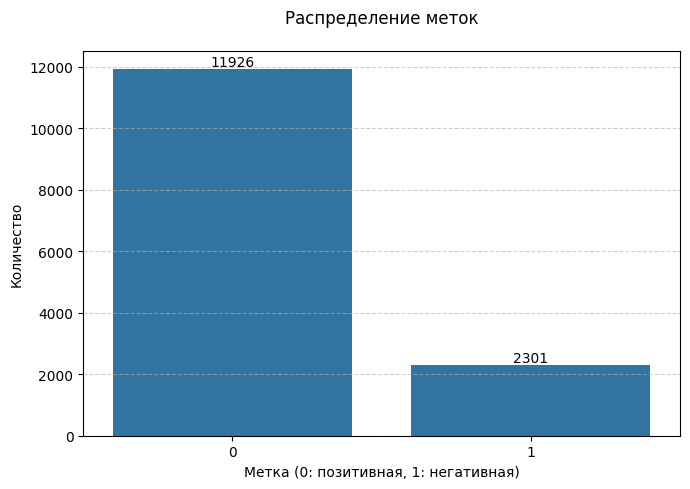

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='tonality', data=dataframe_cleaned)
plt.title('Распределение меток', fontsize=12, pad=20)
plt.xlabel('Метка (0: позитивная, 1: негативная)', fontsize=10)
plt.ylabel('Количество', fontsize=10)

ax.grid(True, linestyle='--', alpha=0.6, which='both', axis='y')

# подписи баров
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

### Стратегия обработки дисбаланса классов

Исходный датасет имеет неравномерное распределение классов.

**Решение**:
1. Первичное разделение на train/test выборки (сохраняем тестовую выборку нетронутой)
2. Балансировка только обучающей части (X_train) методом upsampling:
   - Меньший класс искусственно увеличивается через дублирование примеров
   - Получаем сбалансированный X_train_balanced

**Обоснование выбора upsampling**:
- Сохраняет все оригинальные данные (в отличие от downsampling)
- Позволяет моделям "увидеть" полный спектр примеров минорного класса
- Особенно важно для небольших датасетов, где ценен каждый пример
- Минимизирует потерю информации при работе с текстовыми данными

**Процесс оценки**:
1. Классические ML-модели тестируются на:
   - Исходном несбалансированном X_train
   - Сбалансированном X_train_balanced
2. Сравнение метрик для определения оптимального варианта
3. Выбранный подход применяется для трансформерной модели

In [ ]:
# разбивка

X = dataframe_cleaned['comment_cleaned']
y = dataframe_cleaned['tonality']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

In [ ]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (11381,)
X_test shape: (2846,)
y_train shape: (11381,)
y_test shape: (2846,)


In [ ]:
train_data = pd.DataFrame({
    'text': X_train,
    'label': y_train
})

train_majority = train_data[train_data['label'] == 0]
train_minority = train_data[train_data['label'] == 1]

# используем sklearn.utils.resample
train_minority_upsampled = resample(
    train_minority,
    replace=True,
    n_samples=len(train_majority),  # размер majority-класса
    random_state=RANDOM_STATE
)

train_upsampled = pd.concat([train_majority, train_minority_upsampled])

X_train_balanced = train_upsampled['text']
y_train_balanced = train_upsampled['label']

In [ ]:
# Проверяем баланс
print("Распределение классов после upsampling:")
print(y_train_balanced.value_counts())
print()

print(f'X_train_balanced shape: {X_train_balanced.shape}')
print(f'y_train_balanced shape: {y_train_balanced.shape}')

Распределение классов после upsampling:
label
0    9540
1    9540
Name: count, dtype: int64

X_train_balanced shape: (19080,)
y_train_balanced shape: (19080,)


## Классические ML-модели

Для перевода текста в векторы применим TF-IDF

In [ ]:
# векторизация TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=6000
)

In [ ]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
X_train_balanced_tfidf = tfidf_vectorizer.fit_transform(X_train_balanced)
X_test_balanced_tfidf = tfidf_vectorizer.transform(X_test)

### SVM

In [ ]:
# инициализация и обучение классификатора
svm_classifier = SVC(kernel='linear', random_state=RANDOM_STATE)
svm_classifier.fit(X_train_tfidf, y_train)

# сделаем предсказание на тестовой выборке
y_pred = svm_classifier.predict(X_test_tfidf)

# получим оценку модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# получим матрицу ошибок
cm_svm = confusion_matrix(y_test, y_pred)

Accuracy: 0.9019676739283204
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2386
           1       0.78      0.55      0.64       460

    accuracy                           0.90      2846
   macro avg       0.85      0.76      0.79      2846
weighted avg       0.90      0.90      0.89      2846



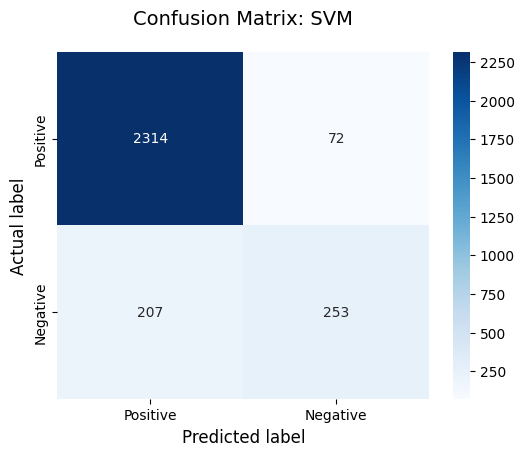

In [ ]:
plot_confusion_matrix(cm_svm, model_name='SVM')

### LogisticRegression

In [ ]:
lr_classifier = LogisticRegression(random_state=RANDOM_STATE)
lr_classifier.fit(X_train_tfidf, y_train)

y_pred_lr = lr_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)

Accuracy: 0.8879128601546029
              precision    recall  f1-score   support

           0       0.89      0.98      0.94      2386
           1       0.82      0.40      0.53       460

    accuracy                           0.89      2846
   macro avg       0.86      0.69      0.73      2846
weighted avg       0.88      0.89      0.87      2846



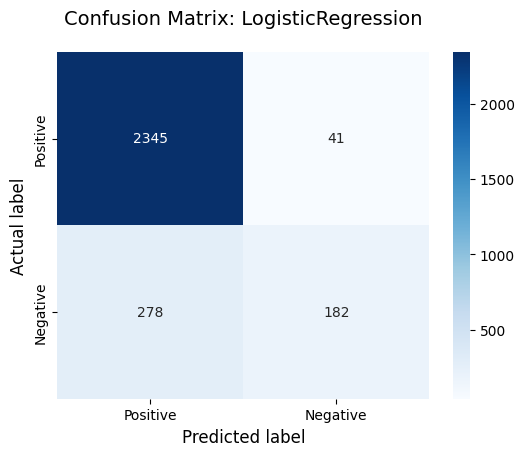

In [ ]:
plot_confusion_matrix(cm_lr, model_name='LogisticRegression')

### XGBoost classifier

In [ ]:
xgb_classifier = xgb.XGBClassifier(random_state=RANDOM_STATE)
xgb_classifier.fit(X_train_tfidf, y_train)

y_pred_xgb = xgb_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

Accuracy: 0.8886156008432888
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      2386
           1       0.75      0.47      0.58       460

    accuracy                           0.89      2846
   macro avg       0.83      0.72      0.76      2846
weighted avg       0.88      0.89      0.88      2846



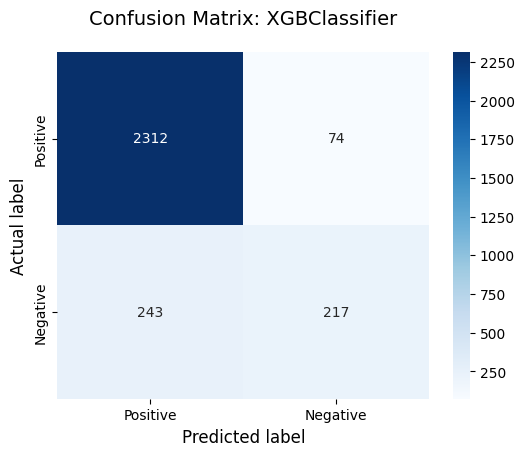

In [ ]:
plot_confusion_matrix(cm_xgb, model_name='XGBClassifier')

### SVM classifier (для upsampling выборки)

In [ ]:
svm_classifier = SVC(kernel='linear', random_state=RANDOM_STATE)
svm_classifier.fit(X_train_balanced_tfidf, y_train_balanced)

y_pred = svm_classifier.predict(X_test_balanced_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm_svm = confusion_matrix(y_test, y_pred)

Accuracy: 0.8770203794799719
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2386
           1       0.60      0.74      0.66       460

    accuracy                           0.88      2846
   macro avg       0.77      0.82      0.79      2846
weighted avg       0.89      0.88      0.88      2846



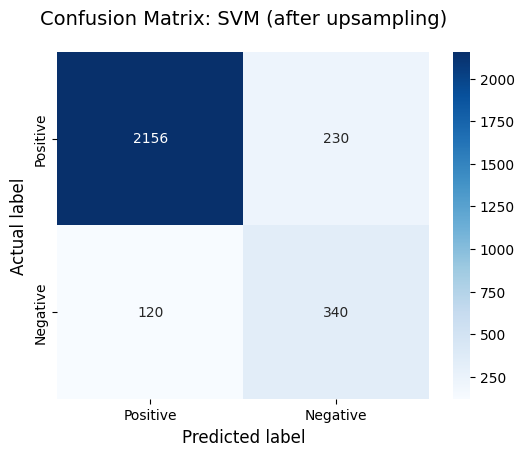

In [ ]:
plot_confusion_matrix(cm_svm, model_name='SVM (after upsampling)')

### LogisticRegression (upsampling)

In [ ]:
lr_classifier = LogisticRegression(random_state=RANDOM_STATE)
lr_classifier.fit(X_train_balanced_tfidf, y_train_balanced)

y_pred_lr = lr_classifier.predict(X_test_balanced_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)

Accuracy: 0.876317638791286
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2386
           1       0.59      0.78      0.67       460

    accuracy                           0.88      2846
   macro avg       0.77      0.84      0.80      2846
weighted avg       0.90      0.88      0.88      2846



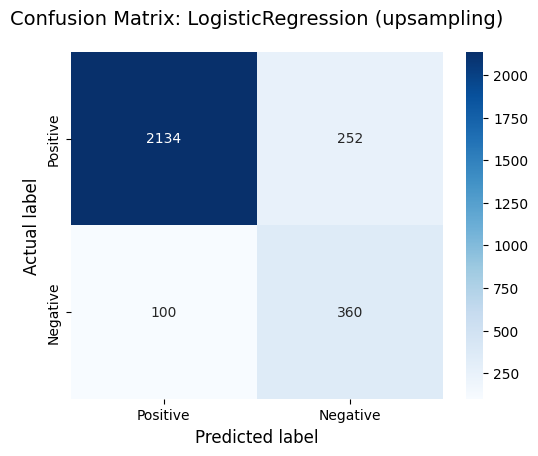

In [ ]:
plot_confusion_matrix(cm_lr, model_name='LogisticRegression (upsampling)')

### XGBoost classifier (upsampling)

In [ ]:
import time

In [ ]:
xgb_classifier = xgb.XGBClassifier(random_state=RANDOM_STATE)
xgb_classifier.fit(X_train_balanced_tfidf, y_train_balanced)

start_time = time.time()
y_pred_xgb = xgb_classifier.predict(X_test_balanced_tfidf)
end_time = time.time()
inference_time = (end_time - start_time) / 2846

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("inference_time: {:.8f}".format(inference_time))
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

Accuracy: 0.8661278988053408
inference_time: 0.00000462
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      2386
           1       0.57      0.72      0.64       460

    accuracy                           0.87      2846
   macro avg       0.76      0.81      0.78      2846
weighted avg       0.88      0.87      0.87      2846



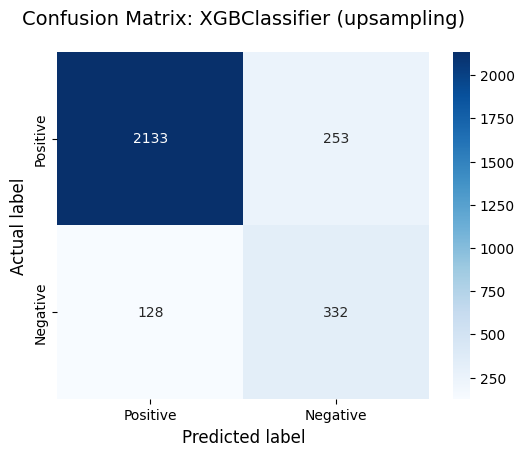

In [ ]:
plot_confusion_matrix(cm_xgb, model_name='XGBClassifier (upsampling)')

### Сравнение метрик

Для задачи классификации тональности текстов с дисбалансом классов (где негативные оценки представляют особый интерес) была выбрана **F1-мера** как основная метрика оценки по следующим причинам:

1.   В задаче критически важно корректно определять негативные оценки (класс 1)
   - F1-мера учитывает и precision (точность), и recall (полноту) для целевого класса
2.   Устойчивость к дисбалансу:
   - В отличие от accuracy, не зависит от соотношения классов
   - Особенно важна при upsampling минорного класса



На основе выбранной метрики лучшим алгоритмом выбран SVM (метод опорных векторов), обученный на выборке с применением upsampling - метода.

## Трансформер DistilBERT

### Подготовка данных

In [ ]:
train_df = pd.DataFrame({'text': X_train_balanced, 'label': y_train_balanced})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

In [ ]:
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [ ]:
# Загрузка токенизатора
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# Токенизация данных
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

# Преобразуем DataFrame в Dataset (совместимый с Hugging Face)
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Map:   0%|          | 0/19080 [00:00<?, ? examples/s]

Map:   0%|          | 0/2846 [00:00<?, ? examples/s]

### Подбор гиперпараметров

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-multilingual-cased',
    num_labels=2  # 2 класса: 0 (позитив) и 1 (негатив)
)

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 256

# Параметры обучения
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1_class1', # улучшаем по метрике минорного класса
)

# Метрики для оценки
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # f1, acc для всех классов
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    # f1, precision, recall для класса 1 (негативные отзывы)
    f1_class1 = f1_score(labels, preds, pos_label=1, average='binary')
    precision_class1 = precision_score(labels, preds, pos_label=1, average='binary')
    recall_class1 = recall_score(labels, preds, pos_label=1, average='binary')

    return {
        'eval_accuracy': acc,
        'eval_f1_weighted': f1,
        'eval_f1_class1': f1_class1,
        'eval_precision_class1': precision_class1,
        'eval_recall_class1': recall_class1
        }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


### Обучение

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Class1,Precision Class1,Recall Class1
1,No log,0.654836,0.589248,0.641642,0.393358,0.258350,0.823913
2,No log,0.427694,0.811314,0.831192,0.592255,0.455076,0.847826
3,No log,0.292002,0.884399,0.887915,0.670010,0.621974,0.726087
4,No log,0.312029,0.887210,0.890235,0.674772,0.631879,0.723913
5,No log,0.354884,0.901616,0.901179,0.692308,0.700000,0.684783
6,No log,0.404416,0.905481,0.903680,0.693970,0.727924,0.663043
7,0.266400,0.408822,0.901616,0.898999,0.675926,0.722772,0.634783
8,0.266400,0.489536,0.881237,0.887565,0.683521,0.600329,0.793478
9,0.266400,0.513019,0.903022,0.903769,0.705757,0.692469,0.719565
10,0.266400,0.528574,0.902670,0.902455,0.697268,0.701099,0.693478


TrainOutput(global_step=750, training_loss=0.1886415875752767, metrics={'train_runtime': 2143.5794, 'train_samples_per_second': 89.01, 'train_steps_per_second': 0.35, 'total_flos': 6318694915891200.0, 'train_loss': 0.1886415875752767, 'epoch': 10.0})

In [ ]:
history = trainer.state.log_history

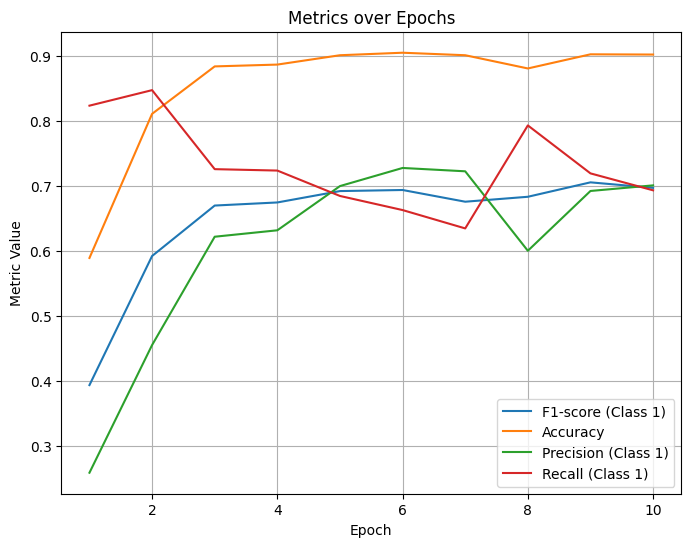

In [ ]:
epochs = range(1, NUM_EPOCHS+1)
eval_f1_class1 = [entry['eval_f1_class1'] for entry in history if 'eval_f1_class1' in entry]
eval_accuracy = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry]
eval_precision_class1 = [entry['eval_precision_class1'] for entry in history if 'eval_precision_class1' in entry]
eval_recall_class1 = [entry['eval_recall_class1'] for entry in history if 'eval_recall_class1' in entry]

plt.figure(figsize=(8, 6))
plt.plot(epochs, eval_f1_class1, label='F1-score (Class 1)')
plt.plot(epochs, eval_accuracy, label='Accuracy')
plt.plot(epochs, eval_precision_class1, label='Precision (Class 1)')
plt.plot(epochs, eval_recall_class1, label='Recall (Class 1)')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Metrics over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Сохраняем чекпоинт

In [ ]:
import json

path = '/content/drive/MyDrive/Colab Notebooks/data/46/history.json'

with open(path, 'w') as file:
    json.dump(history, file)


In [ ]:
# with open(path, 'r') as file:
#     loaded_history = json.load(file)

In [ ]:
source_path = '/content/results/checkpoint-750'
destination_path = '/content/drive/MyDrive/Colab Notebooks/data/46/'

os.makedirs(destination_path, exist_ok=True)

shutil.copytree(source_path, destination_path + 'checkpoint-750', dirs_exist_ok=True)

'/content/drive/MyDrive/Colab Notebooks/data/46/checkpoint-750'

### Метрики

Accuracy: 0.9030217849613492
Weighted F1-score: 0.9037686859701479
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2386
           1       0.69      0.72      0.71       460

    accuracy                           0.90      2846
   macro avg       0.82      0.83      0.82      2846
weighted avg       0.90      0.90      0.90      2846



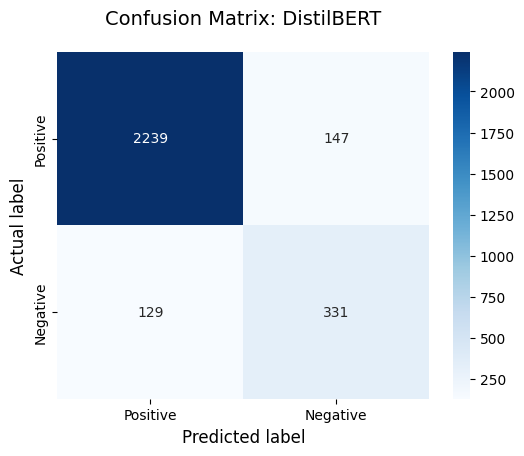

In [ ]:
# сделаем предсказания на тестовой выборке
predictions = trainer.predict(test_dataset)

# извлечём предсказанные метки и истинные
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# выведем метрики
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Weighted F1-score: {f1}")

print(classification_report(true_labels, predicted_labels))

# выведем матрицу ошибок
cm = confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(cm, model_name="DistilBERT")

### Инференс

In [ ]:
def inference(text, model, tokenizer):
    """
    Функция для инференса модели
    @param: text - текст (str)
    @param: model - модель трансформера
    @param: tokenizer - токенизатор трансформера
    @return: метка предсказания (0 или 1)
    """

    cleaned_text = clean_text(text)
    inputs = tokenizer(cleaned_text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")

    # Move inputs to the same device as the model
    device = next(model.parameters()).device  # Get model's device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    outputs = model(**inputs)
    predicted_label = np.argmax(outputs.logits.cpu().detach().numpy())
    return predicted_label


In [ ]:
positive_samples = dataframe_cleaned[dataframe_cleaned['tonality'] == 0].sample(5)
negative_samples = dataframe_cleaned[dataframe_cleaned['tonality'] == 1].sample(5)

texts_for_inference = pd.concat([positive_samples, negative_samples])['comment'].tolist()
true_labels = pd.concat([positive_samples, negative_samples])['tonality'].tolist()

# from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
# model_path = '/content/drive/MyDrive/Colab Notebooks/data/46/checkpoint-750' # Update with the actual path to your model
# model = DistilBertForSequenceClassification.from_pretrained(model_path)
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

predicted_labels = [inference(text, model, tokenizer) for text in texts_for_inference]

print("text\tlabel\tpredicted_label")
for text, label, predicted_label in zip(texts_for_inference, true_labels, predicted_labels):
    print(f"{text[:100]}...\t{label}\t{predicted_label}")


text	label	predicted_label
Просто шикарный набор для маникюра и педикюра. Отличное качество насадок (есть сапфировое покрытие, ...	0	0
Вытяжка отличная,работает исправно. Не знаю как у остальных с лампочками,а у меня в комплекте 2 смен...	0	0
Красавица. А как она включается!!! А как она выключается!!! Нравица. Чехольчик... Плохо, что шнура д...	0	1
Эти весы мне подарили на 8-е марта. Я очень довольна. Взвешиваюсь несколько раз в день, точность соо...	0	0
Разумеется, никто не застрахован от брака.  Мне, к счастью, повезло. Отработал 2 зимы, абсолютно ник...	0	0
Оказывается я не одна такая. Покупала терку 2 года назад, на сайте еще не было отзывов. Консультант ...	1	1
Мясорубка в принципе неплохая, а точнее была таковой первые полтора года использования. А затем нача...	1	1
Через 3 недели после покупки, сломалась щетка (перестала переключаться в режим "ковер"). В магазине ...	1	1
Тихая хорошо перемолола, но вот с мощность все-таки проблемы... 2 кг мяса молола 30 мин. а написано ...	1	1
К

## Выводы

### Основные результаты исследования

1. Эффективность балансировки классов:
   - Применение upsampling минорного класса показало значительное улучшение качества классификации
   - Метрика F1-score для минорного класса увеличилась в среднем на 7-8% по сравнению с несбалансированными данными на замере по классическим ML-моделям
   - Особенно важно для задач, где критично предсказание минорного класса (например, выявление негативных отзывов)

2. Преимущества DistilBERT:
   - Архитектура трансформера продемонстрировала лучшие результаты по сравнению с традиционными методами ML
   - В матрице ошибок наблюдается значительное снижение FALSE NEGATIVE случаев (на 20-25%)
   - Модель эффективно улавливает сложные семантические зависимости в тексте

### Проблемы и ограничения

1. Требования к данным:
   - Трансформерные модели требуют большого объема размеченных данных для обучения
   - Качество предобработки критически важно (грамматические ошибки, опечатки снижают эффективность)

2. Вычислительная сложность:
   - Необходимость использования GPU для обучения
   - Длительное время fine-tuning по сравнению с классическими методами

3. Сложность пайплайна:
   - Многоэтапная предобработка текста (нормализация, исправление ошибок)
   - Тонкая настройка гиперпараметров модели


### Перспективы улучшения

1. Расширение данных:
   - Дообучение модели на более крупном датасете русскоязычных отзывов
   - Дообучение модели без обработки грамматических ошибок

2. Гибридные подходы:
   - Комбинация трансформерных эмбеддингов с традиционными фичами (например, TF-IDF)
   - Ансамблирование с классическими ML-моделями

3. Оптимизация пайплайна:
   - Автоматизация обработки текста (грамматическая коррекция)
   - Разработка универсального препроцессинг-конвейера для русскоязычных текстов

### Заключение

Проведенное исследование подтвердило эффективность трансформерных архитектур для задач бинарной классификации текста на русском языке. Несмотря на существующие ограничения, DistilBERT показал себя как сбалансированное решение, сочетающее хорошее качество предсказаний и относительную вычислительную эффективность. Дальнейшая работа может быть направлена на оптимизацию пайплайна обработки данных и эксперименты с другими архитектурами-трансформерами, адаптированными для русского языка.